# Hackathon - Particle Images
## Problem Statement 
*   One of the important aspects of searches for new physics at the Large Hadron Collider (LHC) involves the classification of various High-Energy Particles in collision events
*   The goal of this challenge is to develop a model which classifies electron and photon electromagnetic showers as accurately as possible based on the detector images provided in the dataset below (one pixel = one channel of the detector)
*   The preferred metric for evaluating the model is ROC curve (Receiver Operating Characteristic curve) and the AUC (Area Under the ROC Curve) score.
*   Although we are using Keras Framework in this sample notebook, you are free to choose Machine Learning / Deep Learning Framework of your choice. 



## Create the appropriate project folder 

In [4]:
mkdir Particle_Images

mkdir: cannot create directory ‘Particle_Images’: File exists


In [5]:
cd Particle_Images

/content/Particle_Images


In [6]:
mkdir data/

mkdir: cannot create directory ‘data/’: File exists


# Download the Dataset

In [7]:
#!/bin/bash
!wget https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download -O data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
!wget https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download -O data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

--2021-11-15 17:24:56--  https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 188.184.97.72, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87010508 (83M) [application/octet-stream]
Saving to: ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’

data/SingleElectron 100%[===================>]  82.98M  18.6MB/s    in 4.5s    

Last-modified header invalid -- time-stamp ignored.
2021-11-15 17:25:02 (18.6 MB/s) - ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’ saved [87010508/87010508]

--2021-11-15 17:25:02--  https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 128.142.53.28, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79876391

# Import modules

In [8]:
!pip install tensorflow-addons
!pip install tensorflow==2.0.0-beta1

ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0-beta1 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0rc0, 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0rc0, 2.3.0rc1, 2.3.0rc2, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0rc0, 2.4.0rc1, 2.4.0rc2, 2.4.0rc3, 2.4.0rc4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0rc0, 2.5.0rc1, 2.5.0rc2, 2.5.0rc3, 2.5.0, 2.5.1, 2.5.2, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.7.0rc0, 2.7.0rc1, 2.7.0)
ERROR: No matching distribution found for tensorflow==2.0.0-beta1


In [9]:
!pip install tfa
import numpy as np
np.random.seed(69)  # for reproducibility
import h5py
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D,BatchNormalization,AveragePooling2D
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

from tensorboard.plugins.hparams import api as hp
# Load the TensorBoard notebook extension
%load_ext tensorboard

ERROR: Could not find a version that satisfies the requirement tfa (from versions: none)
ERROR: No matching distribution found for tfa


# Keras Model Parameters

In [97]:
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 50       # Training batch size
train_size  = 5000     # Training size 
valid_size  = 1024     # Validation size
test_size   = 1024     # Test size
epochs      = 20       # Number of epochs
doGPU       = False    # Use GPU

## It is recommended to use GPU for training and inference if possible.

In [98]:
if doGPU:
    import tensorflow.compat.v1 as tf
    from tensorflow.compat.v1.keras.backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    set_session(tf.Session(config=config))

# Load Image Data
### Two classes of particles: electrons and photons
### 32x32 matrices (two channels - hit energy and time) for the two classes of particles electrons and photons impinging on a calorimeter (one calorimetric cell = one pixel).
#### Please note that although timing channel is provided, it may not necessarily help the performance of the model.

In [99]:
img_rows, img_cols, nb_channels = 32, 32, 2        
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

# Configure Training / Validation / Test Sets

In [100]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

# Plot sample of training images
### Please note that although timing channel is provided, it may not necessarily help the performance of the model.

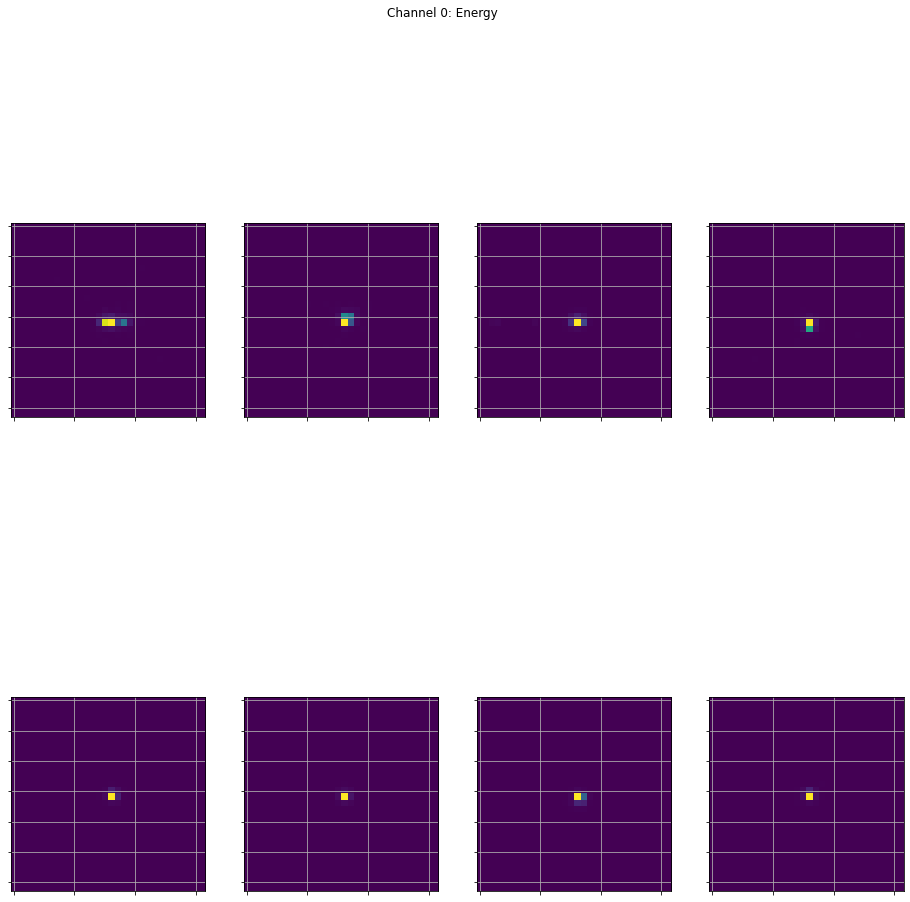

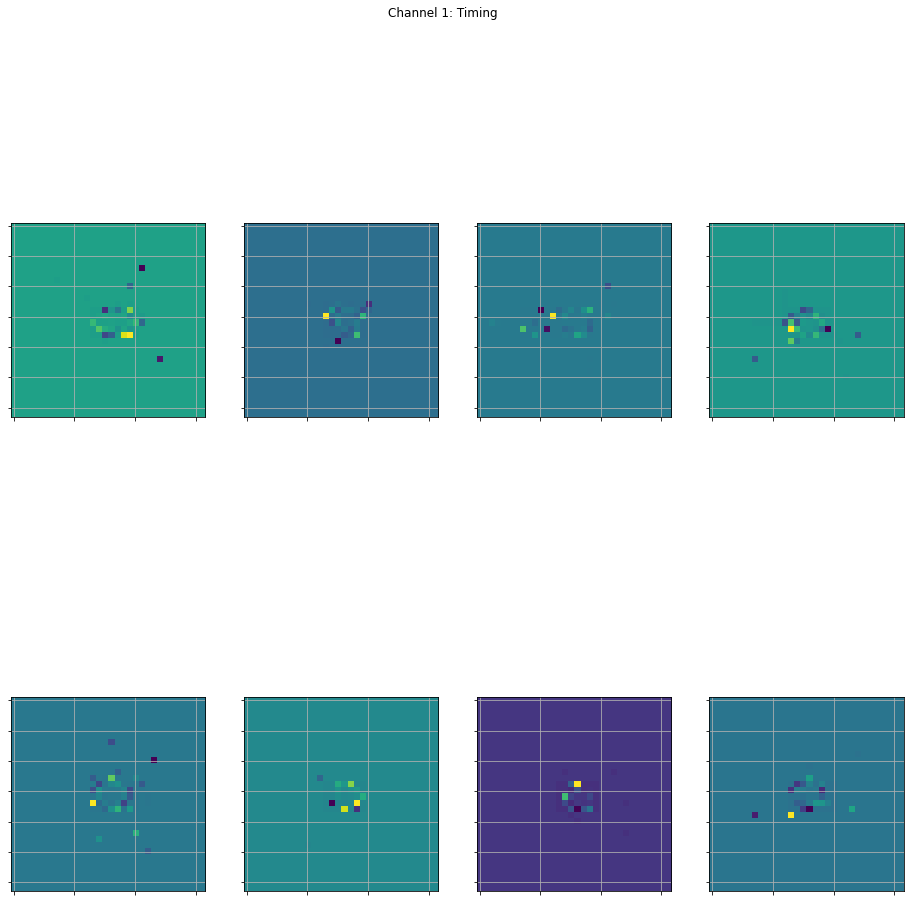

In [101]:
fig, ax = plt.subplots(2, 4,figsize=(16,16))
fig.suptitle("Channel 0: Energy")  # Energy
for i, axi in enumerate(ax.flat):
  axi.imshow(X_train[i,:,:,0])
  axi.grid(True)
  axi.set_xticklabels([])
  axi.set_yticklabels([])
  axi.set_aspect('equal')
  plt.subplots_adjust(wspace=None, hspace=None)

fig, ax = plt.subplots(2, 4,figsize=(16,16))
fig.suptitle("Channel 1: Timing")  # Timing
for i, axi in enumerate(ax.flat):
  axi.imshow(X_train[i,:,:,1])
  axi.grid(True)
  axi.set_xticklabels([])
  axi.set_yticklabels([])
  axi.set_aspect('equal')
  plt.subplots_adjust(wspace=None, hspace=None)



In [102]:
import tensorflow as tf
import tensorflow_addons as tfa


%reload_ext tensorboard
def gaussian_kernel(size: int,
                    mean: float,
                    std: float,
                   ):
    """Makes 2D gaussian Kernel for convolution."""

    d = tf.distributions.Normal(mean, std)

    vals = d.prob(tf.range(start = -size, limit = size + 1, dtype = tf.float32))

    gauss_kernel = tf.einsum('i,j->ij',
                                  vals,
                                  vals)

    return gauss_kernel / tf.reduce_sum(gauss_kernel)

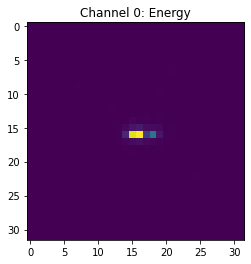

In [103]:
from tensorflow_addons.image import gaussian_filter2d
plt.title("Channel 0: Energy") 
plt.imshow(X_train[0,:,:,0])
kernelized_5 = gaussian_filter2d(X_train[0,:,:,0],filter_shape=2)
kernelized_3 = gaussian_filter2d(X_train[0,:,:,0],filter_shape=6)


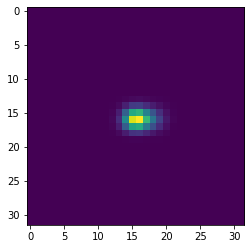

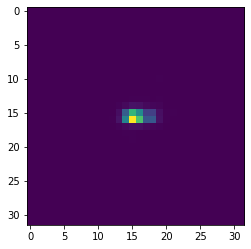

In [104]:
plt.imshow(kernelized_3)
plt.show()
plt.imshow(kernelized_5)

# Define CNN Model
## This is a sample model. You can experiment with the model and try various architectures and other models to achieve the highest possible performance.  

In [105]:
#https://github.com/Natsu6767/Inception-Module-Tensorflow/blob/master/inception_layer.py
def inception_layer(x, conv_1_size, conv_3_reduce_size,
					conv_3_size, conv_5_reduce_size,
					conv_5_size, pool_proj_size,
					name = 'inception'):
	""" Create an Inception Layer """
	with tf.variable_scope(name) as scope:
		conv_1 = conv_layer(x, filter_height = 1, filter_width = 1,
							num_filters = conv_1_size, name = '{}_1x1'.format(name))
		conv_3_reduce = conv_layer(x, filter_height = 1, filter_width = 1,
							num_filters = conv_3_reduce_size, name = '{}_3x3_reduce'.format(name))
		conv_3 = conv_layer(conv_3_reduce, filter_height = 3, filter_width = 3,
							num_filters = conv_3_size, name = '{}_3x3'.format(name))
		conv_5_reduce = conv_layer(x, filter_height = 1, filter_width = 1,
							num_filters = conv_5_reduce_size, name = '{}_5x5_reduce'.format(name))
		conv_5 = conv_layer(conv_5_reduce, filter_height = 5, filter_width = 5,
							num_filters = conv_5_size, name = '{}_5x5'.format(name))
		pool = max_pool(x, stride =1, padding = 'SAME', name = '{}_pool'.format(name))
		pool_proj = conv_layer(pool, filter_height = 1, filter_width = 1,
							num_filters = pool_proj_size, name = '{}_pool_proj'.format(name))
		return tf.concat([conv_1, conv_3, conv_5, pool_proj], axis = 3, name='{}_concat'.format(name))

In [106]:
### Define Convolutional Neural Network (CNN) Model ###
model = Sequential()
model.add(Conv2D(strides=1,
                 filters=40, 
                 activation='relu', 
                 kernel_size=2, 
                 padding='same', 
                 kernel_initializer='TruncatedNormal', 
                 input_shape=(img_rows, img_cols, nb_channels)))
model.add(Conv2D(strides=1,
                 filters=40, 
                 activation='relu', 
                 kernel_size=2, 
                 padding='same', 
                 kernel_initializer='TruncatedNormal', 
                 input_shape=(img_rows, img_cols, nb_channels)))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(strides=1,
                 filters=40, 
                 activation='relu', 
                 kernel_size=2, 
                 padding='same', 
                 kernel_initializer='TruncatedNormal', 
                 input_shape=(img_rows, img_cols, nb_channels)))
model.add(Conv2D(strides=1,
                 filters=40, 
                 activation='relu', 
                 kernel_size=2, 
                 padding='same', 
                 kernel_initializer='TruncatedNormal', 
                 input_shape=(img_rows, img_cols, nb_channels)))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(strides=1,
                 filters=48, 
                 activation='relu', 
                 kernel_size=2, 
                 padding='same', 
                 kernel_initializer='TruncatedNormal', 
                 input_shape=(img_rows, img_cols, nb_channels)))
model.add(Conv2D(strides=1,
                 filters=48, 
                 activation='relu', 
                 kernel_size=2, 
                 padding='same', 
                 kernel_initializer='TruncatedNormal', 
                 input_shape=(img_rows, img_cols, nb_channels)))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(strides=1,
                 filters=56, 
                 activation='relu', 
                 kernel_size=2, 
                 padding='same', 
                 kernel_initializer='TruncatedNormal', 
                 input_shape=(img_rows, img_cols, nb_channels)))
model.add(Conv2D(strides=1,
                 filters=56, 
                 activation='relu', 
                 kernel_size=2, 
                 padding='same', 
                 kernel_initializer='TruncatedNormal', 
                 input_shape=(img_rows, img_cols, nb_channels)))
model.add(BatchNormalization())
#model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Flatten())


model.add(Dense(256, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_initializer='TruncatedNormal'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_init), metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 32, 32, 40)        360       
                                                                 
 conv2d_57 (Conv2D)          (None, 32, 32, 40)        6440      
                                                                 
 batch_normalization_28 (Bat  (None, 32, 32, 40)       160       
 chNormalization)                                                
                                                                 
 average_pooling2d_21 (Avera  (None, 16, 16, 40)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_58 (Conv2D)          (None, 16, 16, 40)        6440      
                                                                 
 conv2d_59 (Conv2D)          (None, 16, 16, 40)       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [107]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-6)
history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)

Epoch 1/40
200/200 [==============================] - 6s 22ms/step - loss: 0.6747 - accuracy: 0.5744 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/40
200/200 [==============================] - 4s 20ms/step - loss: 0.6581 - accuracy: 0.6106 - val_loss: 0.6978 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/40
200/200 [==============================] - 4s 20ms/step - loss: 0.6499 - accuracy: 0.6168 - val_loss: 0.6886 - val_accuracy: 0.5005 - lr: 0.0010
Epoch 4/40
200/200 [==============================] - 4s 20ms/step - loss: 0.6451 - accuracy: 0.6320 - val_loss: 1.0604 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/40
200/200 [==============================] - 4s 20ms/step - loss: 0.6382 - accuracy: 0.6414 - val_loss: 1.7529 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/40
200/200 [==============================] - 4s 20ms/step - loss: 0.6099 - accuracy: 0.6747 - val_loss: 2.3374 - val_accuracy: 0.5000 - lr: 2.0000e-04
Epoch 7/40
200/200 [==============================] - 4s 20m

## Train the Model
### You may further optimize the model, tune hyper-parameters, etc. accordingly to achieve the best performance possible.

## Evaluate the Model  
### Along with the model accuracy, the prefered metric for evaluation is ROC (Receiver Operating Characteristic) curve and the AUC score (Area under the ROC Curve).

In [108]:
"""
# Evaluate on training set
score = model.evaluate(X_train, y_train, verbose=1)
print('\nTraining loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_train)
fpr, tpr, _ = roc_curve(y_train, y_pred)
roc_auc = auc(fpr, tpr)
print('Training ROC AUC:', roc_auc)
"""

# Evaluate on validation set
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

64/64 [==============================] - 1s 7ms/step - loss: 0.6009 - accuracy: 0.6890

Validation loss / accuracy: 0.6009 / 0.6890
Validation ROC AUC: 0.7429981231689453
64/64 [==============================] - 0s 7ms/step - loss: 0.6062 - accuracy: 0.6846

Test loss / accuracy: 0.6062 / 0.6846
Test ROC AUC: 0.7339210510253906


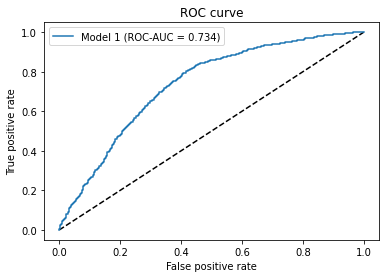

In [109]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#ROC-AUC

# Submission format: 
### Please submit the Google Colab Jupyter Notebook demonstrating your solution in the similar format as illustrated in this notebook. It should contain :
*   The final model architecture, parameters and hyper-parameters yielding the best possible performance,
*   Its Training and Validation accuracy, 
*   ROC curve and the AUC score as shown above.
*   Also, please submit the final trained model containing the model architecture and its trained weights along with this notebook (For example: HDF5 file, .pb file, .pt file, etc.). You are free to choose Machine Learning Framework of your choice. 

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#ROC-AUC

In [ ]:
model = Sequential()
model.add(Conv2D(16, activation='elu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal', input_shape=(img_rows, img_cols, nb_channels)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, activation='elu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, activation='elu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(Conv2D(32, activation='elu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='elu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='elu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_initializer='TruncatedNormal'))
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_init), metrics=['accuracy'])
model.summary()